In [1]:
import pandas as pd
file_path = '/home/abrar/Desktop/Code/Temporal HPC/clean_data.csv'

# Read CSV and ensure datetime columns are parsed correctly
time_columns = ['submit_time', 'eligible_time', 'start_time', 'end_time']
df = pd.read_csv(file_path, parse_dates=time_columns)
# Now 'df' contains the data from the second sheet

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191315 entries, 0 to 191314
Data columns (total 21 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   job_id           191315 non-null  int64         
 1   job_state        191315 non-null  object        
 2   submit_time      191315 non-null  datetime64[ns]
 3   eligible_time    191315 non-null  datetime64[ns]
 4   start_time       191315 non-null  datetime64[ns]
 5   end_time         191315 non-null  datetime64[ns]
 6   run_time         191315 non-null  int64         
 7   wait_time        191315 non-null  float64       
 8   cores_per_task   191315 non-null  int64         
 9   shared           191315 non-null  int64         
 10  partition        191315 non-null  int64         
 11  priority         191315 non-null  int64         
 12  num_tasks        191315 non-null  float64       
 13  state_reason     191315 non-null  object        
 14  num_cores_alloc  191

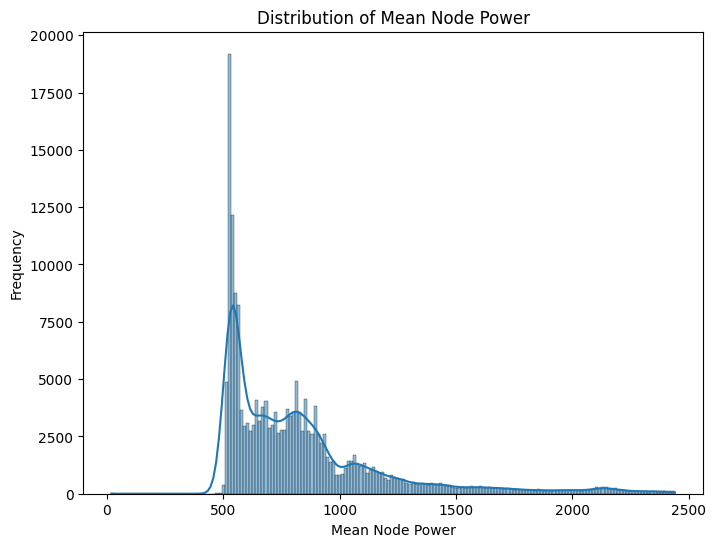

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot distribution curve
plt.figure(figsize=(8,6))
sns.histplot(df['mean_node_power'], kde=True)

# Set title and labels
plt.title('Distribution of Mean Node Power')
plt.xlabel('Mean Node Power')
plt.ylabel('Frequency')

# Display plot
plt.show()

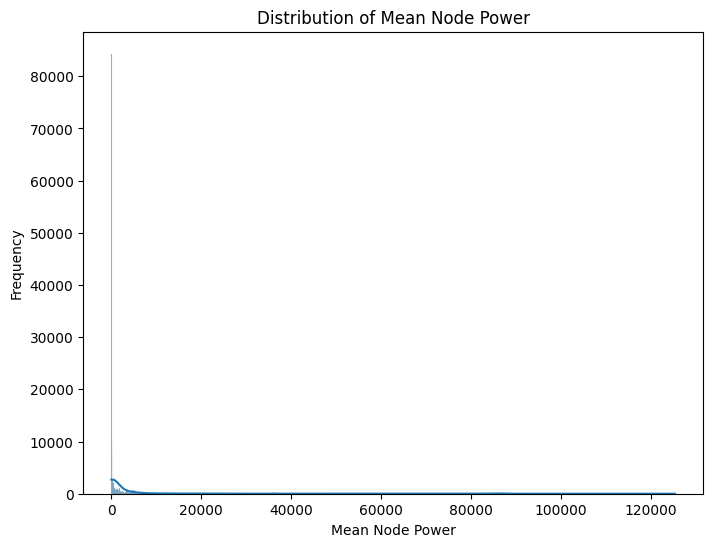

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot distribution curve
plt.figure(figsize=(8,6))
sns.histplot(df['run_time'], kde=True)

# Set title and labels
plt.title('Distribution of Mean Node Power')
plt.xlabel('Mean Node Power')
plt.ylabel('Frequency')

# Display plot
plt.show()

# Splitting dataset into GNN, RL and Test

In [14]:
# Needs to be changed
import pandas as pd
import numpy as np
from sklearn.preprocessing import KBinsDiscretizer

def create_representative_subset(df, subset_size=0.35, random_state=42):
    """
    Create a representative subset of the data using stratified sampling.
    
    Args:
        df: Input DataFrame
        subset_size: Fraction of data to keep (default: 0.35)
        random_state: Random seed for reproducibility
    
    Returns:
        DataFrame containing the representative subset
    """
    # Create a copy to avoid modifying the original
    df = df.copy()
    
    # 1. Create bins for numerical features
    # Use KBinsDiscretizer for more robust binning
    n_bins = 5  # Number of bins for each feature
    
    # Features to bin
    numerical_features = {
        'run_time': n_bins,
        'num_cores_alloc': n_bins,
        'mem_alloc': n_bins,
        'mean_node_power': n_bins
    }
    
    # Create binned features
    for feature, bins in numerical_features.items():
        # Handle skewed distributions with quantile-based binning
        kbd = KBinsDiscretizer(n_bins=bins, encode='ordinal', strategy='quantile')
        
        # Reshape for KBinsDiscretizer
        binned_values = kbd.fit_transform(df[[feature]])
        df[f'{feature}_bin'] = binned_values
    
    # 2. Create time-based bins to ensure temporal coverage
    df['hour_of_day'] = pd.to_datetime(df['submit_time']).dt.hour
    df['day_of_week'] = pd.to_datetime(df['submit_time']).dt.dayofweek
    
    # 3. Define stratification features
    strat_features = [
        'run_time_bin',
        'num_cores_alloc_bin',
        'mem_alloc_bin',
        'mean_node_power_bin',
        'hour_of_day',
        'day_of_week',
        'job_state'
    ]
    
    # 4. Create a composite key for stratification
    df['strat_key'] = df[strat_features].astype(str).agg('_'.join, axis=1)
    
    # 5. Calculate desired number of samples
    n_samples = int(len(df) * subset_size)
    
    # 6. Calculate sampling fractions for each stratum
    stratum_sizes = df['strat_key'].value_counts()
    sampling_fractions = (n_samples * stratum_sizes / len(df)) / stratum_sizes
    # Cap sampling fractions at 1.0
    sampling_fractions = sampling_fractions.clip(upper=1.0)
    
    # 7. Sample from each stratum
    sampled_dfs = []
    for stratum in stratum_sizes.index:
        stratum_df = df[df['strat_key'] == stratum]
        frac = sampling_fractions[stratum]
        sampled_df = stratum_df.sample(
            frac=frac,
            random_state=random_state
        )
        sampled_dfs.append(sampled_df)
    
    # 8. Combine samples
    subset_df = pd.concat(sampled_dfs)
    
    # 9. Clean up temporary columns
    subset_df = subset_df.drop(columns=[
        'run_time_bin', 'num_cores_alloc_bin', 'mem_alloc_bin',
        'mean_node_power_bin', 'strat_key'
    ])
    
    return subset_df

def validate_representation(original_df, subset_df):
    """
    Validate how well the subset represents the original data.
    """
    stats = {}
    
    # Numerical features to check
    numerical_features = [
        'run_time', 'num_cores_alloc', 'mem_alloc', 
        'mean_node_power', 'mean_cpu_power', 'mean_mem_power'
    ]
    
    # Calculate statistics for numerical features
    for feature in numerical_features:
        orig_stats = original_df[feature].describe()
        subset_stats = subset_df[feature].describe()
        
        stats[feature] = {
            'original_mean': orig_stats['mean'],
            'subset_mean': subset_stats['mean'],
            'original_std': orig_stats['std'],
            'subset_std': subset_stats['std'],
            'mean_diff_pct': ((subset_stats['mean'] - orig_stats['mean']) / orig_stats['mean']) * 100
        }
    
    # Calculate categorical distribution differences
    categorical_features = ['job_state', 'state_reason']
    for feature in categorical_features:
        orig_dist = original_df[feature].value_counts(normalize=True)
        subset_dist = subset_df[feature].value_counts(normalize=True)
        
        # Calculate Jensen-Shannon divergence
        stats[feature] = {
            'original_distribution': orig_dist,
            'subset_distribution': subset_dist
        }
    
    return stats

# Example usage:
if __name__ == "__main__":
    # Create the subset
    GNN_df = create_representative_subset(df, subset_size=0.35)
    
    # Validate the representation
    validation_stats = validate_representation(df, GNN_df)
    
    # Print summary statistics
    print(f"Original dataset size: {len(df)}")
    print(f"Subset size: {len(GNN_df)}")
    print(f"Subset percentage: {(len(GNN_df) / len(df)) * 100:.2f}%")
    
    print("\nFeature Statistics:")
    for feature, stats in validation_stats.items():
        if isinstance(stats, dict) and 'mean_diff_pct' in stats:
            print(f"\n{feature}:")
            print(f"Mean difference: {stats['mean_diff_pct']:.2f}%")
            print(f"Original mean: {stats['original_mean']:.2f}")
            print(f"Subset mean: {stats['subset_mean']:.2f}")

/home/abrar/Desktop/Code/Temporal HPC/myenv/lib/python3.12/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/home/abrar/Desktop/Code/Temporal HPC/myenv/lib/python3.12/site-packages/sklearn/preprocessing/_discretization.py:306: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


Original dataset size: 191315
Subset size: 63415
Subset percentage: 33.15%

Feature Statistics:

run_time:
Mean difference: -0.73%
Original mean: 5615.28
Subset mean: 5574.53

num_cores_alloc:
Mean difference: 1.92%
Original mean: 107.32
Subset mean: 109.38

mem_alloc:
Mean difference: 1.28%
Original mean: 213.54
Subset mean: 216.28

mean_node_power:
Mean difference: -0.06%
Original mean: 841.26
Subset mean: 840.77

mean_cpu_power:
Mean difference: 0.32%
Original mean: 142.35
Subset mean: 142.80

mean_mem_power:
Mean difference: 0.19%
Original mean: 44.56
Subset mean: 44.64


In [ ]:
GNN_df.to_csv('GNN_dataset.csv', index=False)

# Feature Engineering

In [15]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
import torch

def engineer_features(df):
    """
    Create advanced features for power prediction with fixed concurrent jobs calculation.
    """
    df = df.copy()
    
    # 1. Resource Utilization Features
    df['cores_per_node'] = df['num_cores_alloc'] / np.maximum(df['num_nodes_alloc'], 1)
    df['mem_per_core'] = df['mem_alloc'] / np.maximum(df['num_cores_alloc'], 1)
    df['gpus_per_node'] = df['num_gpus_alloc'] / np.maximum(df['num_nodes_alloc'], 1)
    
    # 2. Time-based Features
    df['queue_time'] = (df['start_time'] - df['submit_time']).dt.total_seconds()
    df['hour_of_day'] = df['start_time'].dt.hour
    df['day_of_week'] = df['start_time'].dt.dayofweek
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
    
    # 3. Job Efficiency Metrics
    df['runtime_per_core'] = df['run_time'] / np.maximum(df['num_cores_alloc'], 1)
    df['mem_runtime_ratio'] = df['mem_alloc'] * df['run_time']
    
    # 4. Resource Intensity Indicators
    df['is_gpu_job'] = (df['num_gpus_alloc'] > 0).astype(int)
    df['is_large_memory'] = (df['mem_alloc'] > df['mem_alloc'].median()).astype(int)
    df['is_long_running'] = (df['run_time'] > df['run_time'].median()).astype(int)
    
    # 5. Calculate concurrent jobs (fixed version)
    def calculate_concurrent_jobs(df):
        # Create a DataFrame with start and end events
        events = pd.DataFrame({
            'timestamp': pd.concat([df['start_time'], df['end_time']]),
            'event_type': ['start'] * len(df) + ['end'] * len(df)
        })
        
        # Sort by timestamp
        events = events.sort_values('timestamp')
        
        # Calculate running count of jobs
        events['count_change'] = np.where(events['event_type'] == 'start', 1, -1)
        events['concurrent_jobs'] = events['count_change'].cumsum()
        
        # Create a lookup Series with unique timestamps
        concurrent_jobs_lookup = events.groupby('timestamp')['concurrent_jobs'].last()
        
        # Create a function to find the nearest timestamp
        def find_concurrent_jobs(timestamp):
            idx = concurrent_jobs_lookup.index.get_indexer([timestamp], method='nearest')[0]
            return concurrent_jobs_lookup.iloc[idx]
        
        # Apply the lookup function to each job's start time
        return df['start_time'].apply(find_concurrent_jobs)
    
    df['concurrent_jobs'] = calculate_concurrent_jobs(df)
    
    # 6. Time-window based features
    df['hourly_job_count'] = df.groupby(
        [df['start_time'].dt.date, df['start_time'].dt.hour]
    ).cumcount()
    
    # 7. System load features
    df['total_cores_requested'] = df['num_cores_alloc'] * df['concurrent_jobs']
    df['total_memory_requested'] = df['mem_alloc'] * df['concurrent_jobs']
    
    # 8. Normalized features
    df['normalized_runtime'] = df['run_time'] / df['run_time'].mean()
    df['normalized_memory'] = df['mem_alloc'] / df['mem_alloc'].mean()
    
    return df

def create_advanced_job_graph(df, n_neighbors=10):
    """
    Create a more sophisticated graph structure based on multiple similarity metrics.
    """
    # Select features for similarity calculation
    similarity_features = [
        'cores_per_node',
        'mem_per_core',
        'runtime_per_core',
        'concurrent_jobs',
        'normalized_runtime',
        'normalized_memory',
        'hour_of_day',
        'is_gpu_job',
        'is_large_memory',
        'is_long_running'
    ]
    
    # Ensure all features exist and handle missing values
    for feature in similarity_features:
        if feature not in df.columns:
            print(f"Warning: Feature {feature} not found in DataFrame")
            similarity_features.remove(feature)
    
    # Scale features for similarity calculation
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(df[similarity_features])
    
    # Create KNN graph
    knn = NearestNeighbors(n_neighbors=min(n_neighbors, len(df)-1))
    knn.fit(scaled_features)
    
    # Get both distance and indices
    distances, indices = knn.kneighbors(scaled_features)
    
    # Create edge list with weights
    edges = []
    edge_weights = []
    
    for i in range(len(df)):
        for j, dist in zip(indices[i], distances[i]):
            if i != j:
                edges.append([i, j])
                edge_weights.append(1 / (1 + dist))  # Convert distance to similarity
    
    # Convert to PyTorch tensors
    edge_index = torch.tensor(edges, dtype=torch.long).t()
    edge_weight = torch.tensor(edge_weights, dtype=torch.float)
    
    return edge_index, edge_weight

# Example usage
    # Engineer features
if __name__ == "__main__":
    GNN_df = pd.read_csv('GNN_dataset.csv', parse_dates=time_columns)
    GNN_df = engineer_features(GNN_df)
    
    # Print summary of engineered features
    print("\nEngineered Features Summary:")
    print(GNN_df.describe())
    
    # Create graph structure
    edge_index, edge_weight = create_advanced_job_graph(GNN_df)
    
    print("\nGraph Structure Summary:")
    print(f"Number of nodes: {len(GNN_df)}")
    print(f"Number of edges: {edge_index.shape[1]}")
    print(f"Average edge weight: {edge_weight.mean().item():.4f}")


Engineered Features Summary:
              job_id                    submit_time  \
count   63415.000000                          63415   
mean    94998.080218  2020-08-07 18:33:36.083528960   
min         2.000000            2020-05-05 16:01:00   
25%     46515.000000            2020-06-24 08:09:59   
50%     94695.000000            2020-08-18 18:34:17   
75%    143435.000000     2020-09-25 07:58:51.500000   
max    191315.000000            2020-10-12 23:50:26   
std     55569.546669                            NaN   

                       eligible_time                     start_time  \
count                          63415                          63415   
mean   2020-08-07 19:41:22.561082112  2020-08-07 20:38:21.817377536   
min              2020-05-05 16:01:00            2020-05-05 16:01:00   
25%       2020-06-24 08:25:38.500000            2020-06-24 08:25:39   
50%              2020-08-18 18:59:53            2020-08-18 19:22:05   
75%       2020-09-25 12:41:06.500000     2020-09

In [ ]:
GNN_df.to_csv('GNN_dataset_w_feature_eng.csv', index=False)

# GNN Training


In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors

class GNNScheduler(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout=0.2):
        super(GNNScheduler, self).__init__()
        self.dropout = nn.Dropout(dropout)
        
        # Layer Normalization
        self.layer_norm1 = nn.LayerNorm(hidden_dim)
        self.layer_norm2 = nn.LayerNorm(hidden_dim * 2)
        self.layer_norm3 = nn.LayerNorm(hidden_dim * 4)
        self.layer_norm4 = nn.LayerNorm(hidden_dim * 2)
        self.layer_norm5 = nn.LayerNorm(hidden_dim)
        
        # Convolutional layers
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim * 2)
        self.conv3 = GCNConv(hidden_dim * 2, hidden_dim * 4)
        self.conv4 = GCNConv(hidden_dim * 4, hidden_dim * 2)
        self.conv5 = GCNConv(hidden_dim * 2, hidden_dim)
        
        # Skip connection transformations
        self.skip1 = nn.Linear(hidden_dim, hidden_dim * 2)
        self.skip2 = nn.Linear(hidden_dim * 2, hidden_dim)
        
        # Attention mechanism
        self.attention = nn.Linear(hidden_dim, 1)
        
        # Prediction head
        self.linear1 = nn.Linear(hidden_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.linear3 = nn.Linear(hidden_dim // 2, output_dim)
        
        self.relu = nn.LeakyReLU(0.1)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        
        # Encoder path
        x1 = self.conv1(x, edge_index)
        x1 = self.layer_norm1(x1)
        x1 = self.relu(x1)
        x1 = self.dropout(x1)
        
        x2 = self.conv2(x1, edge_index)
        x2 = self.layer_norm2(x2)
        x2 = self.relu(x2)
        x2 = self.dropout(x2)
        
        # Middle layer
        x3 = self.conv3(x2, edge_index)
        x3 = self.layer_norm3(x3)
        x3 = self.relu(x3)
        x3 = self.dropout(x3)
        
        # Decoder path with skip connections
        x4 = self.conv4(x3, edge_index)
        x4 = self.layer_norm4(x4)
        x4 = self.relu(x4)
        x4 = self.dropout(x4)
        x4 = x4 + self.skip1(x1)  # Skip connection with dimension matching
        
        x5 = self.conv5(x4, edge_index)
        x5 = self.layer_norm5(x5)
        x5 = self.relu(x5)
        x5 = self.dropout(x5)
        x5 = x5 + self.skip2(x2)  # Skip connection with dimension matching
        
        # Attention weighting
        attention_weights = torch.sigmoid(self.attention(x5))
        x5 = x5 * attention_weights
        
        # Final prediction
        x = self.linear1(x5)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.linear3(x)
        
        return x

def encode_categorical_features(df, encoder=None, fit=False):
    """Encode categorical features, optionally fitting a new encoder."""
    if encoder is None or fit:
        encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
        encoded_data = encoder.fit_transform(df[['state_reason']])
    else:
        encoded_data = encoder.transform(df[['state_reason']])
    
    encoded_df = pd.DataFrame(
        encoded_data,
        columns=encoder.get_feature_names_out(['state_reason']),
        index=df.index
    )
    return encoded_df, encoder

def prepare_features(df):
    """Prepare numerical features."""
    datetime_cols = ['submit_time', 'eligible_time', 'start_time', 'end_time']
    for col in datetime_cols:
        df[col] = (df[col] - df[col].min()).dt.total_seconds()
    
    numeric_features = [col for col in df.columns if df[col].dtype in ['float64', 'int64']]
    features = [col for col in numeric_features 
               if col not in ['job_id', 'mean_node_power', 'partition', 'eligible_time', 'start_time', 'end_time']]
    
    return df[features]

def create_job_graph(df, features, n_neighbors=5):
    """Create graph structure using KNN."""
    scaler_graph = StandardScaler()
    df_scaled = scaler_graph.fit_transform(df)
    
    knn = NearestNeighbors(n_neighbors=n_neighbors)
    knn.fit(df_scaled)
    A = knn.kneighbors_graph(df_scaled).toarray()
    edge_index = torch.tensor(A.nonzero(), dtype=torch.long)
    
    return edge_index

def train_gnn(model, optimizer, train_data, val_data, epochs=500, scheduler=None, patience=100):  # Increased patience
    """Train the GNN model with improved training stability."""
    model.train()
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    epochs_no_improve = 0
    min_epochs = 250  # Increased minimum epochs
    
    # Weighted loss function
    criterion = nn.SmoothL1Loss(beta=0.1)  # More sensitive to small errors
    
    for epoch in tqdm(range(epochs), desc="Training GNN"):
        # Training step
        model.train()
        optimizer.zero_grad()
        
        out = model(train_data)
        train_loss = criterion(out, train_data.y)
        
        train_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Increased gradient clip
        optimizer.step()
        
        train_losses.append(train_loss.item())
        
        # Validation step
        model.eval()
        with torch.no_grad():
            val_out = model(val_data)
            val_loss = criterion(val_out, val_data.y)
            val_losses.append(val_loss.item())
        
        # Scheduler step
        if scheduler:
            scheduler.step(val_loss)
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}/{epochs}, Training Loss: {train_loss.item():.4f}, '
                  f'Validation Loss: {val_loss.item():.4f}')
        
        # Early stopping with minimum epochs requirement
        if epoch >= min_epochs:
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                epochs_no_improve = 0
                torch.save(model.state_dict(), 'best_gnn_scheduler.pth')
            else:
                epochs_no_improve += 1
            
            if epochs_no_improve == patience:
                print(f'Early stopping triggered at epoch {epoch+1}')
                break
    
    return train_losses, val_losses

# Main training pipeline
def main(df):
    # Read in dataset
    GNN_df = pd.read_csv('GNN_dataset_w_feature_eng.csv', parse_dates=time_columns)
    # 1. Sort data by timestamp
    df_sorted = GNN_df.sort_values('submit_time').copy()
    
    # 2. Split into train (70%), validation (15%), and test (15%)
    train_size = 0.7
    val_size = 0.15
    
    n_samples = len(df_sorted)
    train_end_idx = int(n_samples * train_size)
    val_end_idx = int(n_samples * (train_size + val_size))
    
    train_df = df_sorted.iloc[:train_end_idx]
    val_df = df_sorted.iloc[train_end_idx:val_end_idx]
    test_df = df_sorted.iloc[val_end_idx:]
    
    # 3. Fit encoder on entire dataset first
    encoded_all, encoder = encode_categorical_features(df_sorted, fit=True)
    
    # 4. Prepare numerical features for each split
    train_numeric = prepare_features(train_df)
    val_numeric = prepare_features(val_df)
    test_numeric = prepare_features(test_df)
    
    # 5. Encode categorical features for each split using the fitted encoder
    train_encoded = encoded_all.loc[train_df.index]
    val_encoded = encoded_all.loc[val_df.index]
    test_encoded = encoded_all.loc[test_df.index]
    
    # 6. Combine features
    train_features = pd.concat([train_numeric, train_encoded], axis=1)
    val_features = pd.concat([val_numeric, val_encoded], axis=1)
    test_features = pd.concat([test_numeric, test_encoded], axis=1)
    
    # 7. Scale features
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()
    
    train_scaled = pd.DataFrame(
        scaler_X.fit_transform(train_features),
        columns=train_features.columns,
        index=train_features.index
    )
    val_scaled = pd.DataFrame(
        scaler_X.transform(val_features),
        columns=val_features.columns,
        index=val_features.index
    )
    test_scaled = pd.DataFrame(
        scaler_X.transform(test_features),
        columns=test_features.columns,
        index=test_features.index
    )
    
    # 8. Scale target
    train_y = scaler_y.fit_transform(train_df[['mean_node_power']])
    val_y = scaler_y.transform(val_df[['mean_node_power']])
    test_y = scaler_y.transform(test_df[['mean_node_power']])
    
    # 9. Create graph data
    train_edge_index = create_job_graph(train_scaled, train_features.columns)
    val_edge_index = create_job_graph(val_scaled, val_features.columns)
    test_edge_index = create_job_graph(test_scaled, test_features.columns)
    
    # 10. Create PyTorch Geometric Data objects
    train_data = Data(
        x=torch.tensor(train_scaled.values, dtype=torch.float),
        edge_index=train_edge_index,
        y=torch.tensor(train_y, dtype=torch.float)
    )
    val_data = Data(
        x=torch.tensor(val_scaled.values, dtype=torch.float),
        edge_index=val_edge_index,
        y=torch.tensor(val_y, dtype=torch.float)
    )
    test_data = Data(
        x=torch.tensor(test_scaled.values, dtype=torch.float),
        edge_index=test_edge_index,
        y=torch.tensor(test_y, dtype=torch.float)
    )
    
    # 11. Initialize and train model
    model = GNNScheduler(
        input_dim=train_scaled.shape[1],
        hidden_dim=512,
        output_dim=1,
        dropout=0.2
    )
    
    optimizer = optim.AdamW(
        model.parameters(),
        lr=0.0005,  # Further reduced learning rate
        weight_decay=1e-4,
        amsgrad=True,
        betas=(0.9, 0.999)
    )
    
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.3,
        patience=40,
        verbose=True,
        min_lr=1e-6,
        threshold=1e-4
    )
    
    # 12. Train model
    train_losses, val_losses = train_gnn(
        model, optimizer, train_data, val_data,
        epochs=500, scheduler=scheduler, patience=100  # Increased patience
    )
    
    # 13. Plot training progress
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.yscale('log')
    plt.legend()
    plt.savefig('training_loss.png')
    plt.close()
    
    return model, scaler_X, scaler_y, encoder, test_data, train_df, val_df, test_df

if __name__ == "__main__":
    model, scaler_X, scaler_y, encoder, test_data, train_df, val_df, test_df = main(df)
    
    # Print dataset sizes
    print(f"\nDataset sizes:")
    print(f"Training set: {len(train_df)} samples")
    print(f"Validation set: {len(val_df)} samples")
    print(f"Test set: {len(test_df)} samples")

/tmp/ipykernel_37101/2171579298.py:114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = (df[col] - df[col].min()).dt.total_seconds()
/tmp/ipykernel_37101/2171579298.py:114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = (df[col] - df[col].min()).dt.total_seconds()
/tmp/ipykernel_37101/2171579298.py:114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

Epoch 10/500, Training Loss: 0.5105, Validation Loss: 0.4163


Training GNN:   4%|▍         | 20/500 [02:03<50:38,  6.33s/it]

Epoch 20/500, Training Loss: 0.3347, Validation Loss: 0.4948


Training GNN:   6%|▌         | 30/500 [03:06<49:52,  6.37s/it]

Epoch 30/500, Training Loss: 0.3160, Validation Loss: 0.3839


Training GNN:   8%|▊         | 40/500 [04:10<49:31,  6.46s/it]

Epoch 40/500, Training Loss: 0.3023, Validation Loss: 0.4130


Training GNN:  10%|█         | 50/500 [05:15<48:46,  6.50s/it]

Epoch 50/500, Training Loss: 0.2944, Validation Loss: 0.4187


Training GNN:  12%|█▏        | 60/500 [06:20<47:38,  6.50s/it]

Epoch 60/500, Training Loss: 0.2911, Validation Loss: 0.4157


Training GNN:  14%|█▍        | 70/500 [07:26<46:38,  6.51s/it]

Epoch 70/500, Training Loss: 0.2884, Validation Loss: 0.4356


Training GNN:  16%|█▌        | 80/500 [08:30<45:18,  6.47s/it]

Epoch 80/500, Training Loss: 0.2846, Validation Loss: 0.4274


Training GNN:  18%|█▊        | 90/500 [09:35<43:55,  6.43s/it]

Epoch 90/500, Training Loss: 0.2838, Validation Loss: 0.4241


Training GNN:  20%|██        | 100/500 [10:39<43:02,  6.46s/it]

Epoch 100/500, Training Loss: 0.2820, Validation Loss: 0.4224


Training GNN:  22%|██▏       | 110/500 [11:44<42:07,  6.48s/it]

Epoch 110/500, Training Loss: 0.2820, Validation Loss: 0.4209


Training GNN:  24%|██▍       | 120/500 [12:48<40:57,  6.47s/it]

Epoch 120/500, Training Loss: 0.2818, Validation Loss: 0.4210


Training GNN:  26%|██▌       | 130/500 [13:53<40:21,  6.55s/it]

Epoch 130/500, Training Loss: 0.2817, Validation Loss: 0.4224


Training GNN:  28%|██▊       | 140/500 [15:01<40:18,  6.72s/it]

Epoch 140/500, Training Loss: 0.2806, Validation Loss: 0.4223


Training GNN:  30%|███       | 150/500 [16:05<37:49,  6.48s/it]

Epoch 150/500, Training Loss: 0.2803, Validation Loss: 0.4214


Training GNN:  32%|███▏      | 160/500 [17:11<37:05,  6.55s/it]

Epoch 160/500, Training Loss: 0.2806, Validation Loss: 0.4204


Training GNN:  34%|███▍      | 170/500 [18:15<35:35,  6.47s/it]

Epoch 170/500, Training Loss: 0.2806, Validation Loss: 0.4210


Training GNN:  36%|███▌      | 180/500 [19:20<34:44,  6.52s/it]

Epoch 180/500, Training Loss: 0.2804, Validation Loss: 0.4209


Training GNN:  38%|███▊      | 190/500 [20:26<33:59,  6.58s/it]

Epoch 190/500, Training Loss: 0.2801, Validation Loss: 0.4210


Training GNN:  40%|████      | 200/500 [21:31<32:50,  6.57s/it]

Epoch 200/500, Training Loss: 0.2805, Validation Loss: 0.4213


Training GNN:  42%|████▏     | 210/500 [22:37<32:31,  6.73s/it]

Epoch 210/500, Training Loss: 0.2802, Validation Loss: 0.4212


Training GNN:  44%|████▍     | 220/500 [23:43<30:40,  6.57s/it]

Epoch 220/500, Training Loss: 0.2799, Validation Loss: 0.4215


Training GNN:  46%|████▌     | 230/500 [24:48<29:15,  6.50s/it]

Epoch 230/500, Training Loss: 0.2803, Validation Loss: 0.4211


Training GNN:  48%|████▊     | 240/500 [25:54<28:20,  6.54s/it]

Epoch 240/500, Training Loss: 0.2794, Validation Loss: 0.4210


Training GNN:  50%|█████     | 250/500 [26:59<27:21,  6.56s/it]

Epoch 250/500, Training Loss: 0.2799, Validation Loss: 0.4210


Training GNN:  52%|█████▏    | 260/500 [28:05<26:18,  6.58s/it]

Epoch 260/500, Training Loss: 0.2795, Validation Loss: 0.4210


Training GNN:  54%|█████▍    | 270/500 [29:11<25:05,  6.54s/it]

Epoch 270/500, Training Loss: 0.2795, Validation Loss: 0.4210


Training GNN:  56%|█████▌    | 280/500 [30:16<24:05,  6.57s/it]

Epoch 280/500, Training Loss: 0.2795, Validation Loss: 0.4209


Training GNN:  58%|█████▊    | 290/500 [31:22<23:04,  6.59s/it]

Epoch 290/500, Training Loss: 0.2803, Validation Loss: 0.4208


Training GNN:  60%|██████    | 300/500 [32:27<21:42,  6.51s/it]

Epoch 300/500, Training Loss: 0.2806, Validation Loss: 0.4209


Training GNN:  62%|██████▏   | 310/500 [33:33<20:41,  6.53s/it]

Epoch 310/500, Training Loss: 0.2797, Validation Loss: 0.4209


Training GNN:  64%|██████▍   | 320/500 [34:38<19:37,  6.54s/it]

Epoch 320/500, Training Loss: 0.2800, Validation Loss: 0.4209


Training GNN:  66%|██████▌   | 330/500 [35:43<18:35,  6.56s/it]

Epoch 330/500, Training Loss: 0.2803, Validation Loss: 0.4208


Training GNN:  68%|██████▊   | 340/500 [36:49<17:26,  6.54s/it]

Epoch 340/500, Training Loss: 0.2785, Validation Loss: 0.4209


Training GNN:  70%|███████   | 350/500 [37:54<16:18,  6.52s/it]

Epoch 350/500, Training Loss: 0.2803, Validation Loss: 0.4210


Training GNN:  72%|███████▏  | 360/500 [38:59<15:18,  6.56s/it]

Epoch 360/500, Training Loss: 0.2796, Validation Loss: 0.4211


Training GNN:  74%|███████▍  | 370/500 [40:05<14:09,  6.54s/it]

Epoch 370/500, Training Loss: 0.2788, Validation Loss: 0.4210


Training GNN:  76%|███████▌  | 380/500 [41:10<13:08,  6.57s/it]

Epoch 380/500, Training Loss: 0.2804, Validation Loss: 0.4209


Training GNN:  77%|███████▋  | 387/500 [42:02<12:16,  6.52s/it]

Early stopping triggered at epoch 388

Dataset sizes:
Training set: 44390 samples
Validation set: 9512 samples
Test set: 9513 samples


# Predictions

In [28]:
def predict_node_power(model, test_data, scaler_y):
    """Make predictions using the trained GNN model."""
    model.eval()
    with torch.no_grad():
        # Get predictions
        predictions_scaled = model(test_data)
        # Convert back to original scale
        predictions = scaler_y.inverse_transform(predictions_scaled.numpy())
    return predictions

def evaluate_predictions(true_values, predictions):
    """Calculate various metrics for model evaluation."""
    mse = np.mean((true_values - predictions) ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(true_values - predictions))
    r2 = 1 - np.sum((true_values - predictions) ** 2) / np.sum((true_values - true_values.mean()) ** 2)
    mape = np.mean(np.abs((true_values - predictions) / true_values)) * 100
    
    print("\nModel Performance Metrics:")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f} watts")
    print(f"MAE: {mae:.4f} watts")
    print(f"R² Score: {r2:.4f}")
    print(f"MAPE: {mape:.4f}%")
    
    return {'mse': mse, 'rmse': rmse, 'mae': mae, 'r2': r2, 'mape': mape}

def plot_predictions(true_values, predictions, save_path='prediction_results.png'):
    """Plot actual vs predicted values."""
    plt.figure(figsize=(10, 6))
    plt.scatter(true_values, predictions, alpha=0.5)
    
    # Plot perfect prediction line
    min_val = min(true_values.min(), predictions.min())
    max_val = max(true_values.max(), predictions.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect Prediction')
    
    plt.xlabel('Actual Node Power (watts)')
    plt.ylabel('Predicted Node Power (watts)')
    plt.title('Actual vs Predicted Node Power')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(save_path)
    plt.close()

# Example usage:
if __name__ == "__main__":
    # Assuming you have already trained the model and have the test data
    
    # Make predictions
    predictions = predict_node_power(model, test_data, scaler_y)
    
    # Get actual values (inverse transform if they're scaled)
    actual_values = scaler_y.inverse_transform(test_data.y.numpy())
    
    # Evaluate predictions
    metrics = evaluate_predictions(actual_values, predictions)
    
    # Plot results
    plot_predictions(actual_values, predictions)
    
    # Add predictions to test dataframe
    test_df['predicted_node_power'] = predictions
    test_df['prediction_error'] = test_df['predicted_node_power'] - test_df['mean_node_power']
    
    # Display sample predictions
    print("\nSample Predictions:")
    sample_results = test_df[['mean_node_power', 'predicted_node_power', 'prediction_error']].head()
    print(sample_results)
    
    # Save test results to CSV
    test_df.to_csv('gnn_test_results.csv', index=False)


Model Performance Metrics:
MSE: 68258.2344
RMSE: 261.2628 watts
MAE: 202.9573 watts
R² Score: -0.1222
MAPE: 22.4242%

Sample Predictions:
        mean_node_power  predicted_node_power  prediction_error
162767            540.0            622.275452         82.275452
162771            610.0            633.007568         23.007568
162773           1300.0            665.022278       -634.977722
162775            880.0            638.920044       -241.079956
162776            610.0            633.386353         23.386353
